# Sampling an arbitrary volume
### Objective: Sample a hypercube, subject to a series of constraints g(x) >= 0 as *evenly* as possible

There are two objectives then:
  + Sample efficiency (in time; but acceptance rate is a good proxy for high-dimensional problems)
  + Uniformity – a decent measure would be the average distance between points


In [1]:
import numpy as np
import scipy as sp
import scipy.spatial
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sbn
import pandas as pd
from matplotlib import pyplot as plt

def pull_example(fn):
    """\
    Grab the dimensionality and constraints from a given file. 
    
    """
    gs = list()
    dim = 0
    for i, line in enumerate(open(fn)):
        if dim is 0:
            dim = int(line.strip())
        elif i == 1:
            assert len(line.strip().split()) == dim, 'Example point does not match dimensionality'
        elif line[0] != '#' and '>=' in line:
            gs.append(line.strip().split('>=')[0].strip())
    return {'dim': dim, 'constraints': gs}

# read in the project examples
EXAMPLES = {k: pull_example('/Users/chartl/Downloads/citrine-challenge/%s.txt' % k) for k in ['example', 'alloy', 'mixture', 'formulation']}


def subset_accepting(X, constraints):
    """\
    Given a set of points, and constrants g(x) [as callable functions], subset just to the
    points that fall into the valid volume
    
    """
    print(X.shape)
    constraint_mat = np.vstack([np.apply_along_axis(c, 1, X) < 0 for c in constraints])
    in_region = np.logical_not(np.apply_along_axis(np.any, 0, constraint_mat))
    return X[in_region, :]


def str2fx(xstr):
    """\
    Given a stringified constraint such as
    
    1 - x[0] - x[1]
    
    convert it to a callable function
    
    """
    def f(x):
        return eval(xstr, {'__builtins__': None}, {'x': x } )
    return f

def eval_dataset(X, const_strs, max_kpass=1000):
    constraints = [str2fx(s) for s in const_strs]
    X_pass = subset_accepting(X, constraints)
    rate = X_pass.shape[0]/X.shape[0]
    if X_pass.shape[0] > max_kpass:
        X_pass = X_pass[:max_kpass]
    meddist = np.median(sp.spatial.distance_matrix(X_pass, X_pass))
    return rate, meddist



# The trivial baseline is Monte Carlo simulation. The acceptance rate will be the volume of the object. No frills.

In [2]:
# baseline: just sample from the hypercube

def baseline_sampler(ndim, constraints=None, K=5000):
    return np.random.uniform(size=(K, ndim))

eval_dataset(baseline_sampler(EXAMPLES['example']['dim']), EXAMPLES['example']['constraints'])

(5000, 4)


(0.182, 0.557794988753426)

# Another option is to switch from rejection sampling to a more effective likelihood sampler (No U-Turn), and place potentials on the constraints to push out-of-bounds trajectories back towards the acceptance region.


In [3]:
def potential_sampler(ndim, constraint_str, eps=0, lam_in=0, lam_out=5, 
                      nsample=500, tune=1000, chains=3, cores=3, 
                      nuts_kwargs=None, init='jitter+adapt_diag', latent=False):
    with pm.Model() as mod:
        if not latent:
            x = pm.Uniform('x', shape=ndim)
        else:
            # in cases where the constraint set represents
            # a small volume of the cube; we would like a
            # latent representation that operates on a nicer scale
            # where potentials aren't so sharp.
            z = pm.Normal('z', shape=ndim)
            x = pm.Deterministic('x', tt.exp(pm.Normal.dist(0,1).logcdf(z)))
        model_constraints = dict()
        for i, const in enumerate(constraint_str):
            cname = 'g%d' % i
            g = pm.Deterministic(cname, eval(const))
            pname = '%s_pot' % cname
            pm.Potential(pname, tt.switch(tt.lt(g, eps), lam_out*g, lam_in*g))
            model_constraints[cname] = g
        trace = pm.sample(nsample, init=init, chains=chains, cores=3, tune=1000, nuts_kwargs=nuts_kwargs)
    return trace


def advi_sampler(ndim, constraint_str, eps=0, lam_in=0, lam_out=5, nsample=10000, nfit=100000):
    with pm.Model() as mod:
        x = pm.Uniform('x', shape=ndim)
        model_constraints = dict()
        for i, const in enumerate(constraint_str):
            cname = 'g%d' % i
            g = pm.Deterministic(cname, eval(const))
            pname = '%s_pot' % cname
            pm.Potential(pname, tt.switch(tt.lt(g, eps), lam_out*g, lam_in*g))
            model_constraints[cname] = g
        advi_fit = pm.fit(n=nfit, method='fullrank_advi',obj_n_mc=3)
        trace = advi_fit.sample(nsample)
    return trace


    

sampled_tr = potential_sampler(
    ndim=EXAMPLES['example']['dim'],
    constraint_str=EXAMPLES['example']['constraints'],
    nsample=1000,
    eps=0,
    lam_in=0,
    lam_out=10
)
eval_dataset(sampled_tr['x'], EXAMPLES['example']['constraints'])



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1287.60draws/s]


(3000, 4)


(0.6736666666666666, 0.5558597611018867)

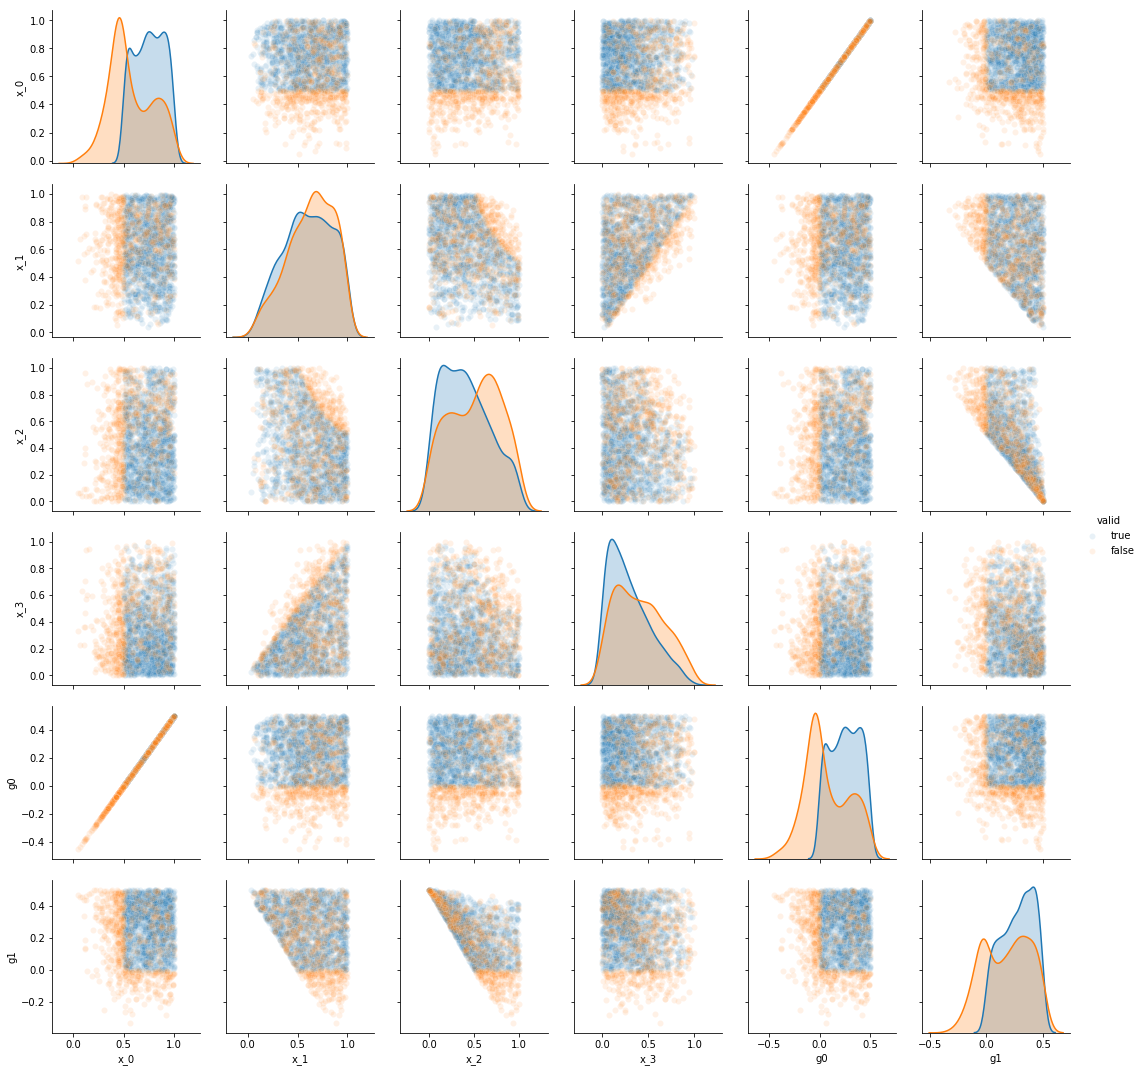

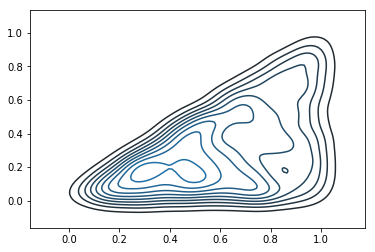

In [4]:
def joint_trace(trace, varnames, k=1000, valid_idx=None):
    vars_ = dict()
    for vn in varnames:
        if len(trace[vn].shape) > 1:
            for j in range(trace[vn].shape[1]):
                vars_['%s_%d' % (vn, j)] = trace[vn][:k,j]
        else:
            vars_[vn] = trace[vn][:k]
    df = pd.DataFrame(vars_)
    if valid_idx is not None:
        valid_idx = np.array([x for x in valid_idx if x < k])
        vld = np.array(['false'] * df.shape[0])
        vld[valid_idx]='true'
        df['valid'] = vld
        sbn.pairplot(df, hue='valid', plot_kws={'alpha': 0.1})
    else:
        sbn.pairplot(df, plot_kws={'alpha': 0.1})

valid, nvalid = 0, 0
for vn in sampled_tr.varnames:
    if vn[0] == 'g':
        valid += np.greater_equal(sampled_tr[vn], 0)
        nvalid += 1
valid = np.array(np.where((valid == nvalid))[0])
joint_trace(sampled_tr, ['x', 'g0', 'g1'], valid_idx=valid, k=2000)

plt.figure()
sbn.kdeplot(sampled_tr['x'][valid[:1500],1], sampled_tr['x'][valid[:1500],3])

# Observations

Observation 1: The blue spike at x0 (corresponding to the g0 constraint) suggests that, even though the potential is 0 within the acceptance region, the density is slightly higher near the constraints.

However, uniformity is *NOT* the goal. Instead it is equal spacing. We can kill two birds with one stone by running a few samplers (constraint-biased and interior-biased); merging the samples, and running a really simple landmark discovery algorithm

In [9]:
DEFAULT_LAM=[1, 15]
DEFAULT_ALPHA=[-0.1, -0.2]
def sample_many(dim, const_str, nsample=1000, chains=3, lam=None, alpha=None):
    cons_fx = [str2fx(s) for s in const_str]
    X = list()
    if lam is None:
        lam = DEFAULT_LAM
    if alpha is None:
        alpha = DEFAULT_ALPHA
    for l in lam:
        for a in alpha:
            sampled_tr = potential_sampler(ndim=dim, constraint_str=const_str,
                                           nsample=nsample, chains=chains, eps=0,
                                           lam_in=a*l,lam_out=l)
            X.append(sampled_tr['x'])
    return np.vstack(X)


multisample = sample_many(EXAMPLES['example']['dim'], EXAMPLES['example']['constraints'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2736.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2447.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:07<00:00, 839.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:08<00:00, 716.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
# an idea: oversample and thin by using landmark points
def get_landmarks(X, constraints, forget=3, k_landmarks=1000):
    Xp = subset_accepting(X, constraints)
    landmark_set = list()
    landmark_dist = np.zeros((Xp.shape[0],))
    # initialize
    idx = np.random.randint(Xp.shape[0])
    landmark_dist = np.linalg.norm(Xp-Xp[idx,:], axis=1)
    for _ in range(forget):
        idx = np.argmax(landmark_dist)
        landmark_dist = np.linalg.norm(Xp-Xp[idx,:], axis=1)
    landmark_set.append(idx)
    for j in range(1, k_landmarks):
        idx = np.argmax(landmark_dist)
        landmark_dist = np.minimum(landmark_dist, np.linalg.norm(Xp-Xp[idx,:],axis=1))
        landmark_set.append(idx)
    return Xp[np.array(landmark_set),:]


def multipotential_sampler(dim, constraints, k_landmarks=1000, X=None):
    X = sample_many(dim, constraints)
    return get_landmarks(X, [str2fx(c) for c in constraints], k_landmarks)

tr_lm = get_landmarks(multisample, [str2fx(c) for c in EXAMPLES['example']['constraints']])
print(eval_dataset(multisample, EXAMPLES['example']['constraints']))
eval_dataset(tr_lm, EXAMPLES['example']['constraints'])

(12000, 4)
(12000, 4)
(0.39641666666666664, 0.5553764423990507)
(1000, 4)


(1.0, 0.5782587295437167)

A purely optimization method would be to try to minimize the total free energy

$E(X) = \mathrm{exp}\{-\sum_{i,j} ||X_i-X_j||^2\}$

subject to the constraints. A constraint will need to convert

`x[2]/(0.5 + x[1]) - x[0] --> Xo[:,2]/(0.5 + Xo[:,1]) - Xo[:,0]`

Since we want $g(x) > 0$ we should take $c(g) = \frac{1}{g}$

In [12]:
def as_theano_f(const):
    const = const.replace('[', '[:,')
    def g(Xo):
        return eval(const, {'__builtins__': None}, {'x': Xo} )
    return g

def min_energy(X, constraint_str, iters=100):
    theano.config.compute_test_value = 'ignore'
    Xi = tt.matrix('base_input')
    Delta = theano.shared(0*X)
    Xo = Xi + Delta
    dif = Xo.reshape((Xo.shape[0], 1, -1)) - Xo.reshape((1, Xo.shape[0], -1))
    cost_dist = -(dif**2).sum()
    cost = cost_dist
    for const in constraint_str:
        g = as_theano_f(const)(Xo)
        cost_g = 1/(4*g)
        cost += cost_g.sum()
    # don't forget to add in the hypercube constraints!
    for j in range(X.shape[1]):
        h = Xo[:,j]
        h2 = 1 - Xo[:,j]
        cost_h = 1/(4*h) + 1/(4*h2)
        cost += cost_h.sum()
    dim_adj = min(1., 4./X.shape[1])
    alpha = np.var(X)*1e-7*dim_adj**2 # smaller learning rate in higher dimensions and narrower regions
    grad_updates = [(Delta, Delta - alpha * theano.grad(cost, Delta))]
    train = theano.function([Xi],cost_dist,updates=grad_updates)
    for _ in range(iters):
        energy = train(X)
        if ( _ % (int(iters/5)) == 0 ):
            print(energy)
    to_ret = theano.function([Xi], Xo)(X)
    theano.config.compute_test_value = 'raise'
    return to_ret

const_fx = [str2fx(c) for c in EXAMPLES['example']['constraints']]
more_lm = get_landmarks(multisample, const_fx, k_landmarks=1200)
Xnew = get_landmarks(min_energy(more_lm, EXAMPLES['example']['constraints'], iters=500), const_fx, k_landmarks=1000)


eval_dataset(Xnew, EXAMPLES['example']['constraints'])

(12000, 4)
-594534.7377485035
-596464.7173277056
-599543.4903472417
-602740.2515315338
-605997.9036477539
(1200, 4)
(1000, 4)


(1.0, 0.5824475715365152)

In [13]:
def minenergy_landmark(dim, const_str, Xinit=None):
    const_fx = [str2fx(c) for c in const_str]
    if Xinit is None:
        Xinit = sample_many(dim, const_str)
    X_lm1 = get_landmarks(Xinit, const_fx, k_landmarks=1500)
    if dim <= 4:
        p = 1
    else:
        p = 4./dim
    X_op1 = min_energy(X_lm1, const_str, 1+int(500*p))  # fewer iterations in high dimensions
    return get_landmarks(X_op1, const_fx, k_landmarks=1000)

In [14]:
import time
SAMPLERS = {
    'baseline': lambda a, b: baseline_sampler(a, b, 25000),
    'potential': lambda a, b: potential_sampler(a,b)['x'],  # returns a trace
    'mp_landmark': multipotential_sampler,
    'me_landmark': minenergy_landmark
}

def eval_example(dim, constraints):
    results = dict()
    for name, fx in SAMPLERS.items():
        try:
            start = time.time()
            X = fx(dim, constraints)
            end = time.time()
            elapsed = end - start
            eval_result = eval_dataset(X, constraints)
            results[name] = {'time': elapsed, 'valid': eval_result[0], 'spread': eval_result[1]}
        except:
            pass
    return results


In [16]:
example_evals = dict()
for dname, dparams in EXAMPLES.items():
    print(dname)
    if dname not in example_evals:
        example_evals[dname] = eval_example(dparams['dim'], dparams['constraints'])

example
(25000, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:03<00:00, 1483.67draws/s]


(1500, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2212.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1608.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:09<00:00, 608.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:10<00:00, 587.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


(12000, 4)
(1000, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1881.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1832.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:09<00:00, 601.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:08<00:00, 679.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


(12000, 4)
-914321.3764129685
-1077889112.8746989
-1087082506.9226046
-1096354371.260673
-1105705287.3503325
-1115135891.8243248
(1500, 4)
(1000, 4)
alloy
(25000, 11)


/Users/chartl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:04<00:00, 1085.00draws/s]


(1500, 11)


/Users/chartl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 980.15draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 938.28draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1279.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1274.67draws/s]


(12000, 11)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1279.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1300.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [37:21<00:00,  2.68draws/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1023.45draws/s]


(12000, 11)
mixture
(25000, 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:01<00:00, 3332.05draws/s]


(1500, 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4186.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4130.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2415.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2268.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


(12000, 2)
(1000, 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4144.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3906.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2378.42draws/s]
The acceptance probability does not match the target. It is 0.703679533617078, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2222.86draws/s]
The number of effective sampl

(12000, 2)
-517752.10956661234
-519779.3790459038
-522683.45341370726
-525691.9312355522
-528757.4614827042
-531861.296026514
(1500, 2)
(1000, 2)
formulation
(25000, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:02<00:00, 1653.30draws/s]


(1500, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2285.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2354.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1098.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1011.31draws/s]


(12000, 4)
(1000, 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1883.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1939.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 892.56draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:07<00:00, 813.66draws/s]


(12000, 4)
-50636.43213547958
-75535.12269514908
-75631.53551455555
-75761.8377237674
-75912.35017286331
-76077.06612359751
(1500, 4)
(1000, 4)


In [17]:
from pprint import pprint
pprint(example_evals)
Y = sample_many(EXAMPLES['alloy']['dim'], EXAMPLES['alloy']['constraints'])

{'alloy': {'baseline': {'spread': nan,
                        'time': 0.006390094757080078,
                        'valid': 0.0},
           'potential': {'spread': nan,
                         'time': 13.385360956192017,
                         'valid': 0.0}},
 'example': {'baseline': {'spread': 0.5554503588140609,
                          'time': 0.002202749252319336,
                          'valid': 0.18748},
             'me_landmark': {'spread': 0.5844572682263915,
                             'time': 82.08000993728638,
                             'valid': 1.0},
             'mp_landmark': {'spread': 0.5722331294509873,
                             'time': 33.44262504577637,
                             'valid': 1.0},
             'potential': {'spread': 0.5549727359134604,
                           'time': 4.3014020919799805,
                           'valid': 0.49466666666666664}},
 'formulation': {'baseline': {'spread': 0.15068014465256221,
                           

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1251.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1195.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1203.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [x]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1251.51draws/s]


In [19]:
tr = advi_sampler(EXAMPLES['alloy']['dim'], EXAMPLES['alloy']['constraints'], 
                      lam_out=7000, nfit=25000, nsample=40000)
Y = tr['x']
#Y = baseline_sampler(EXAMPLES['alloy']['dim'], K=50000)
cfx = [str2fx(c) for c in EXAMPLES['alloy']['constraints']]
Y_lm = get_landmarks(Y, cfx)
Y_lmb = get_landmarks(Y, cfx, 1100)
Y_op = minenergy_landmark(EXAMPLES['alloy']['dim'], EXAMPLES['alloy']['constraints'], Xinit=Y_lmb)
print(eval_dataset(Y,EXAMPLES['alloy']['constraints']))
print(eval_dataset(Y_lm, EXAMPLES['alloy']['constraints']))
print(eval_dataset(Y_op, EXAMPLES['alloy']['constraints']))

  0%|          | 0/25000 [00:00<?, ?it/s]/Users/chartl/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/chartl/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/chartl/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(

(40000, 11)
(40000, 11)
(1000, 11)
-5458.826806717489
-6762991.390769175
-6764471.4089565985
-6764499.734398794
-6764501.707599687
-6764504.338297504
(1500, 11)
(40000, 11)
(0.40165, 0.025903093356233118)
(1000, 11)
(1.0, 0.034263637797715504)
(1000, 11)
(1.0, 0.036205028061585716)


In [ ]:
DEFAULT_TEMPS = [0.01, 0.1, 1, 10, 100]
def multi_stein_sampler(ndim, constraint_str, lam_out=5, nfit=1000, nsample=200, temps=None):
    if temps is None:
        temps = DEFAULT_TEMPS
    X = list()
    for temp in temps:
        with pm.Model() as mod:
            x = pm.Uniform('x', shape=ndim)
            model_constraints = dict()
            for i, const in enumerate(constraint_str):
                cname = 'g%d' % i
                g = pm.Deterministic(cname, eval(const))
                pname = '%s_pot' % cname
                pm.Potential(pname, tt.switch(tt.lt(g, 0), lam_out*g, 0))
                model_constraints[cname] = g
            svgd = pm.SVGD(n_particles=nsample, temperature=temp)
            fit_res = svgd.fit(nfit)
            tr = fit_res.sample(nsample)
        X.append(tr['x'])
    return np.vstack(X)

Y2 = multi_stein_sampler(EXAMPLES['alloy']['dim'], EXAMPLES['alloy']['constraints'], lam_out=10**3)
print(eval_dataset(Y2,EXAMPLES['alloy']['constraints']))

 37%|███▋      | 370/1000 [00:08<00:14, 43.71it/s]

In [ ]:
# is it even feasible?
alloy_matrix_X = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                           [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
                           [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  1,  0 , 0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  -1,  0 , 0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  -1,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  -1,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  -1,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  -1,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  -1,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  -1,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  -1,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  -1,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -1]])
alloy_matrix_b = np.array([0.174-0.003-0.005, 
                           0.0003+0.0005-0.017,
                           -0.0004, 0.0035,
                           -0.0004,0.028,
                           -0.0008, 0.014,
                           -0.001, 0.037, 
                           -0.0002, 0.008, 
                           -0.0003, 0.0016,
                           -0.0006, 0.005, 
                           -0.0001, 0.002, 
                           -0.0005, 0.001,
                           -0.008, 0.12, 
                           -0.0003, 0.005])
print(alloy_matrix_b.shape)
print(alloy_matrix_X.shape)

import scipy as sp
import scipy.optimize
c = np.ones(11)

res = sp.optimize.linprog(c, A_ub=-alloy_matrix_X, b_ub=alloy_matrix_b)
res

In [ ]:
np.var(np.random.uniform(size=1000))